<a href="https://colab.research.google.com/github/Jinukki/KJU/blob/master/3minuteGAN(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import os
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torchvision.utils import save_image
import numpy as np

In [0]:
EPOCHS = 300
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print('다음 장치를 사용합니다.', DEVICE)

다음 장치를 사용합니다. cuda


In [0]:
trainset = datasets.FashionMNIST('./.data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]))
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = BATCH_SIZE, shuffle = True)


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw
Processing...
Done!


In [0]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    # 레이블을 임베딩 처리
    self.embed = nn.Embedding(10,10)

    self.model = nn.Sequential(nn.Linear(110,256), nn.LeakyReLU(0.2, inplace=True), nn.Linear(256,512), nn.LeakyReLU(0.2, inplace=True), nn.Linear(512,1024), nn.LeakyReLU(0.2, inplace=True), nn.Linear(1024,784), nn.Tanh())

  def forward(self, z, labels):
    c = self.embed(labels)
    x = torch.cat([z,c],1)
    return self.model(x)

class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.embed = nn.Embedding(10,10)

    self.model = nn.Sequential(nn.Linear(794,1024), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.3), nn.Linear(1024,512), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.3), nn.Linear(512,256), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(0.3), nn.Linear(256,1), nn.Sigmoid())

  def forward(self, x, labels):
    c = self.embed(labels)
    x = torch.cat([x, c], 1)
    return self.model(x)

In [0]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [0]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
  for i, (images, labels) in enumerate(train_loader):
    images = images.reshape(BATCH_SIZE, -1).to(DEVICE)

    real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
    fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

    labels = labels.to(DEVICE)
    outputs = D(images, labels)
    # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
    g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)
    fake_images = G(z, g_label)

    outputs = D(fake_images, g_label)
    # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs
    # 판별자의 오차 계산
    d_loss = d_loss_real + d_loss_fake

    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    fake_images = G(z, g_label)
    outputs = D(fake_images, g_label)
    # 생성자가 판별자를 속였는지에 대한 오차 계산
    g_loss = criterion(outputs, real_labels)
    
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

  print('이폭 [{}/{}] d_loss:{:.4f} g_loss:{:.4f} D(x):{:.2f} D(G(z)):{:.2f}'. format(epoch, EPOCHS, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))    

이폭 [0/300] d_loss:0.5419 g_loss:4.0920 D(x):0.92 D(G(z)):0.24
이폭 [1/300] d_loss:0.2540 g_loss:3.9692 D(x):0.91 D(G(z)):0.10
이폭 [2/300] d_loss:0.2099 g_loss:5.4184 D(x):0.93 D(G(z)):0.07
이폭 [3/300] d_loss:0.5337 g_loss:2.5672 D(x):0.88 D(G(z)):0.20
이폭 [4/300] d_loss:0.7417 g_loss:3.1266 D(x):0.78 D(G(z)):0.19
이폭 [5/300] d_loss:0.6772 g_loss:2.6877 D(x):0.80 D(G(z)):0.20
이폭 [6/300] d_loss:0.4184 g_loss:2.8183 D(x):0.86 D(G(z)):0.14
이폭 [7/300] d_loss:0.7576 g_loss:2.3598 D(x):0.85 D(G(z)):0.32
이폭 [8/300] d_loss:0.8197 g_loss:1.8113 D(x):0.77 D(G(z)):0.29
이폭 [9/300] d_loss:1.0740 g_loss:1.8803 D(x):0.70 D(G(z)):0.29
이폭 [10/300] d_loss:0.7814 g_loss:1.5563 D(x):0.75 D(G(z)):0.30
이폭 [11/300] d_loss:0.6953 g_loss:1.6332 D(x):0.79 D(G(z)):0.26
이폭 [12/300] d_loss:0.8614 g_loss:1.8112 D(x):0.64 D(G(z)):0.21
이폭 [13/300] d_loss:0.6289 g_loss:1.8676 D(x):0.77 D(G(z)):0.21
이폭 [14/300] d_loss:0.9602 g_loss:1.4252 D(x):0.68 D(G(z)):0.30
이폭 [15/300] d_loss:1.0674 g_loss:1.3675 D(x):0.71 D(G(z)):0.37
이폭

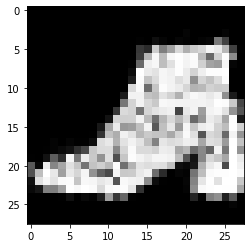

In [0]:
iter_number = 9
z = torch.randn(1, 100).to(DEVICE)
g_label = torch.full((1,), iter_number, dtype=torch.long).to(DEVICE)
sample_images = G(z, g_label)
sample_images_img = np.reshape(sample_images.data.cpu().numpy()[0],(28,28))
plt.imshow(sample_images_img, cmap='gray')
plt.show()